In [2]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import os
from torchsummary import summary
import matplotlib.pyplot as plt
import cv2
!pip install tqdm
from tqdm.notebook import tqdm
import numpy as np
import torchvision
from torch import nn, optim
transform = transforms.Compose([
    transforms.ToTensor(),
])
from helper import (
    noisy_images,
    training_loop_supervised,
    training_loop_unsupervised,
    visualize_reconstructions
)

BATCH_SIZE = 32 # feel free to change this & use this variable whenenver you're asked for a batch size


c:\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Task 1: Supervised Learning with CNNs

### Part 1: CIFAR-10 Classification

Loading the CIFAR-10 dataset from `torchvision.datasets`, train on the training set, and evaluate on the test set.

In [3]:
#base path
data_path = fr'./'

# normalizing and converitng to the tensors
transform = torchvision.transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# making test-train splits 
train_data =  torchvision.datasets.CIFAR10(data_path, train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
test_data = torchvision.datasets.CIFAR10(data_path, train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=False)

# printing the dimensions
print("train length: ",len(train_data))
print("val length: ",len(test_data))

Files already downloaded and verified
Files already downloaded and verified
train length:  50000
val length:  10000


### Visualizing the Dataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


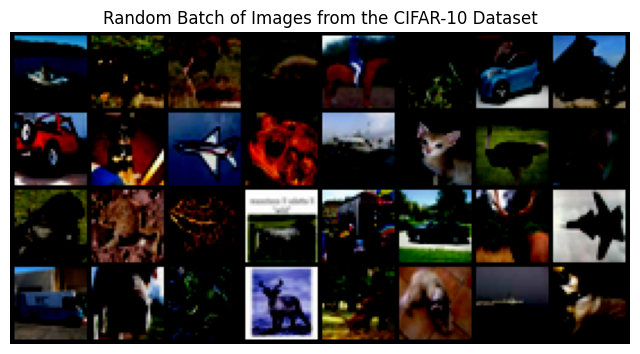

In [4]:
# Visualizing the data:
def imshow(img):
    img = img
    npimg = img.numpy()
    plt.figure(figsize=(8, 8))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.title("Random Batch of Images from the CIFAR-10 Dataset")
    plt.show()

# Get a batch of training data
dataiter = iter(train_loader)
images, _ = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images[0:32]))


#### Define your CNN Class below.
Add multiple convolutional layers, as well as Batch Normalization and dropout layers along with the ReLU activation function in the convolutional block/encoder. Follow it up with a classifier layer that takes in the logits and spits out the class probabiltiies.

In [5]:
# with 3 res blocks, it's 70ish
import torch.nn.functional as F

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, in_channels*2, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(in_channels*2)
        self.relu = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(in_channels*2, in_channels*3, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(in_channels*3)
        self.stride = stride

        self.conv3 = nn.Conv2d(in_channels*3, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels)
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.stride != 1 or x.size(1) != out.size(1):
            residual = F.avg_pool2d(residual, 2, stride=2)
            zeros_pads = torch.zeros(residual.size(0), out.size(1) - residual.size(1), residual.size(2), residual.size(3)).to(residual.device)
            residual = torch.cat([residual, zeros_pads], dim=1)

        out += residual
        out = self.relu(out)

        return out

class CNN(nn.Module):
    def __init__(self, dropout_rate=0.3):
        super(CNN, self).__init__()

        # Initial convolutional layer
        self.conv_init = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn_init = nn.BatchNorm2d(8)
        self.relu_init = nn.ReLU(inplace=True)

        # Residual blocks
        self.res_block1 = ResidualBlock(8, 8)
        self.res_block2 = ResidualBlock(8, 16, stride=2)
        self.res_block3 = ResidualBlock(16, 32, stride=2)

        # Global average pooling
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)

        # Classifier layers
        self.classifier = nn.Sequential(
            nn.Linear(32, 10)
        )

    def forward(self, x):
        x = self.conv_init(x)
        x = self.bn_init(x)
        x = self.relu_init(x)

        x = self.res_block1(x)
        x = self.res_block2(x)
        x = self.res_block3(x)

        x = self.global_avg_pool(x)
        x = x.view(x.size(0), -1)  # Flatten the output for the classifier
        x = self.classifier(x)

        return x

### Implement a training loop function for Supervised Learning in `helper.py`.

This function should return the training loss & test accuracy history, as well as save the model with the best test accuracy.

In [6]:
model = CNN()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

summary(model, input_size=(3, 32, 32), batch_size=BATCH_SIZE, device=device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [32, 8, 32, 32]             216
       BatchNorm2d-2            [32, 8, 32, 32]              16
              ReLU-3            [32, 8, 32, 32]               0
            Conv2d-4           [32, 16, 32, 32]           1,152
       BatchNorm2d-5           [32, 16, 32, 32]              32
              ReLU-6           [32, 16, 32, 32]               0
            Conv2d-7           [32, 24, 32, 32]           3,456
       BatchNorm2d-8           [32, 24, 32, 32]              48
              ReLU-9           [32, 24, 32, 32]               0
           Conv2d-10            [32, 8, 32, 32]           1,728
      BatchNorm2d-11            [32, 8, 32, 32]              16
             ReLU-12            [32, 8, 32, 32]               0
    ResidualBlock-13            [32, 8, 32, 32]               0
           Conv2d-14           [32, 16,

## Relevant helper.py

In [7]:
def training_loop_supervised(model, train_loader, test_loader, num_epochs,
                             criterion, optimizer, device, model_path):
    """
    Trains and evaluates a PyTorch image classification model, saving the model with the best accuracy on the test dataset.

    Args:
    - model: The PyTorch model to be trained and evaluated.
    - train_loader: DataLoader for the training data.
    - test_loader: DataLoader for the testing data.
    - num_epochs: Number of epochs to train the model.
    - criterion: Loss function used for training.
    - optimizer: Optimization algorithm used for training.
    - device: The device ('cuda' or 'cpu') to perform training and evaluation on.
    - model_path: Path to save the model achieving the best accuracy on the test set.

    Returns:
    - train_loss_history: List of average training losses for each epoch.
    - test_accuracy_history: List of test accuracies for each epoch.
    """
    print("HAAAAAAAAAAA")
    model.to(device)
    train_loss_history = []
    test_accuracy_history = []
    # Training loop
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_train_loss = total_loss / len(train_loader)
        train_loss_history.append(avg_train_loss)

        # Evaluate on the test set
        model.eval()
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        test_accuracy = correct / total
        test_accuracy_history.append(test_accuracy)

        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Loss: {avg_train_loss:.4f}, '
              f'Test Accuracy: {test_accuracy:.2%}')

        # Save the model if it has the best accuracy on the test set
        if test_accuracy == max(test_accuracy_history):
            torch.save(model.state_dict(), model_path)

    print('Training finished!')

    # Code here
    print("train_loss_history", train_loss_history)
    print("test_accuracy_history", test_accuracy_history)
    return train_loss_history, test_accuracy_history


def training_loop_unsupervised(model, task, train_loader, test_loader, num_epochs,
                             criterion, optimizer, device, model_path):
    """
    Trains and evaluates a PyTorch image classification model, saving the model with the best accuracy on the test dataset.

    Args:
    - model: The PyTorch model to be trained and evaluated.
    - task: string, either 'reconstruction' or 'denoising'
    - train_loader: DataLoader for the training data.
    - test_loader: DataLoader for the testing data.
    - num_epochs: Number of epochs to train the model.
    - criterion: Loss function used for training.
    - optimizer: Optimization algorithm used for training.
    - device: The device ('cuda' or 'cpu') to perform training and evaluation on.
    - model_path: Path to save the model achieving the best accuracy on the test set.

    Returns:
    - train_loss_history: List of average training losses for each epoch.
    - test_loss_history: List of test losses for each epoch.
    """
    model.to(device)
    train_loss_history = []
    test_loss_history = []

    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0.0

        for images, _ in train_loader:
            images = images.to(device)

            if task == 'denoising':
                noisy_imgs = add_gaussian_noise(images)  # Add Gaussian noise
                outputs = model(noisy_imgs)
            elif task == 'reconstruction':
                outputs = model(images)
            else:
                raise ValueError("Invalid task! Choose 'reconstruction' or 'denoising'.")

            loss = criterion(outputs, images)  # Calculate reconstruction loss
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)
        train_loss_history.append(avg_train_loss)

        # Evaluate on the test set
        model.eval()
        total_test_loss = 0.0

        with torch.no_grad():
            for images, _ in test_loader:
                images = images.to(device)

                if task == 'denoising':
                    noisy_imgs = add_gaussian_noise(images)  # Add Gaussian noise
                    outputs = model(noisy_imgs)
                elif task == 'reconstruction':
                    outputs = model(images)
                else:
                    raise ValueError("Invalid task! Choose 'reconstruction' or 'denoising'.")

                # Calculate reconstruction loss
                loss = criterion(outputs, images)
                total_test_loss += loss.item()

        avg_test_loss = total_test_loss / len(test_loader)
        test_loss_history.append(avg_test_loss)

        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {avg_train_loss:.4f}, '
              f'Test Loss: {avg_test_loss:.4f}')

        # Save the model if it has the best test loss
        if avg_test_loss == min(test_loss_history):
            torch.save(model.state_dict(), model_path)

    print('Training finished!')

    return train_loss_history, test_loss_history



def noisy_images(images, mean=0.0, std=0.5):
    """
    Adds Gaussian noise to a batch of images.

    Parameters:
    - images: tensor of images of shape (N, C, H, W), where N is the batch size,
              C is the number of channels, H is the height, and W is the width.
    - mean: Mean of the Gaussian noise.
    - std: Standard deviation of the Gaussian noise.

    Returns:
    - Tensor of noisy images of the same shape as the input.
    """
    # Code here
    noise = torch.randn_like(images) * std + mean
    noisy_images = images + noise
    return noisy_images


def add_gaussian_noise(images, mean=0.0, std=0.5):
    """
    Adds Gaussian noise to a batch of images.

    Parameters:
    - images: tensor of images of shape (N, C, H, W), where N is the batch size,
              C is the number of channels, H is the height, and W is the width.
    - mean: Mean of the Gaussian noise.
    - std: Standard deviation of the Gaussian noise.

    Returns:
    - Tensor of noisy images of the same shape as the input.
    """
    # Generate Gaussian noise with the same shape as the input images
    noise = torch.randn_like(images) * std + mean

    # Add the noise to the input images
    noisy_images = images + noise

    # Clamp the pixel values between 0 and 1
    noisy_images = torch.clamp(noisy_images, min=0.0, max=1.0)

    return noisy_images

def visualize_reconstructions(test_loader, model, device, task='reconstruction'):
    """
    Visualizes original and reconstructed images from a test dataset.

    Args:
    - test_loader: DataLoader for the test dataset.
    - model: Trained model for image reconstruction or denoising.
    - device: The device (e.g., 'cuda' or 'cpu') the model is running on.
    - task: The task to perform - either 'reconstruction' or 'denoising'.
    """
    dataiter = iter(test_loader)
    images, labels = next(dataiter)

    if task == 'denoising':
        images = noisy_images(images)  # Apply noise if the task is denoising

    recons = model(images.to(device))

    images_np = images.cpu().numpy()
    recons_np = recons.cpu().detach().numpy()

    indices = np.random.choice(images_np.shape[0], 9, replace=False)
    selected_images = images_np[indices]
    selected_recons = recons_np[indices]
    selected_labels = labels.numpy()[indices]

    fig, axs = plt.subplots(2, 9, figsize=(15, 4))

    for i in range(9):
        axs[0, i].imshow(np.transpose(selected_images[i], (1, 2, 0)), interpolation='none', cmap='gray')
        axs[0, i].set_title(f"GT: {selected_labels[i]}")
        axs[0, i].axis('off')

        axs[1, i].imshow(np.transpose(selected_recons[i], (1, 2, 0)), interpolation='none', cmap='gray')
        axs[1, i].set_title(f"Recon: {selected_labels[i]}")
        axs[1, i].axis('off')

    plt.tight_layout()
    plt.show()


In [ ]:

# Define a loss criterion
criterion = torch.nn.CrossEntropyLoss()


# Define an optimizer (e.g., Adam)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

num_epochs = 15

# Device configuration
model.to(device)
model_path = fr"/content/drive/MyDrive/DL/PA3/model/CNN_classifier_PA3_24100238.pth" # change this according to where you wanna save the model weights
train_hist, test_hist = training_loop_supervised(model, train_loader, test_loader, num_epochs,
                                                 criterion, optimizer, device, model_path)

print("train_hist", train_hist)
# Plot the training loss & test accuracy history



HAAAAAAAAAAA
Epoch [1/15], Loss: 1.1217, Test Accuracy: 58.03%
Epoch [2/15], Loss: 0.9716, Test Accuracy: 66.05%
Epoch [3/15], Loss: 0.8836, Test Accuracy: 68.75%
Epoch [4/15], Loss: 0.8153, Test Accuracy: 70.73%
Epoch [5/15], Loss: 0.7657, Test Accuracy: 71.45%
Epoch [6/15], Loss: 0.7202, Test Accuracy: 73.12%
Epoch [7/15], Loss: 0.6812, Test Accuracy: 72.44%
Epoch [8/15], Loss: 0.6491, Test Accuracy: 72.36%
Epoch [9/15], Loss: 0.6200, Test Accuracy: 70.69%
Epoch [10/15], Loss: 0.5938, Test Accuracy: 74.38%
Epoch [11/15], Loss: 0.5736, Test Accuracy: 73.73%
Epoch [12/15], Loss: 0.5535, Test Accuracy: 74.39%
Epoch [13/15], Loss: 0.5333, Test Accuracy: 74.84%
Epoch [14/15], Loss: 0.5166, Test Accuracy: 74.88%
Epoch [15/15], Loss: 0.4971, Test Accuracy: 74.90%
Training finished!
train_loss_history [1.121744385994304, 0.971612453918018, 0.8836166085032247, 0.8153237225225819, 0.7657140646596698, 0.7201990722619054, 0.6811860324552906, 0.6490752699658694, 0.6200017469465885, 0.593768392568

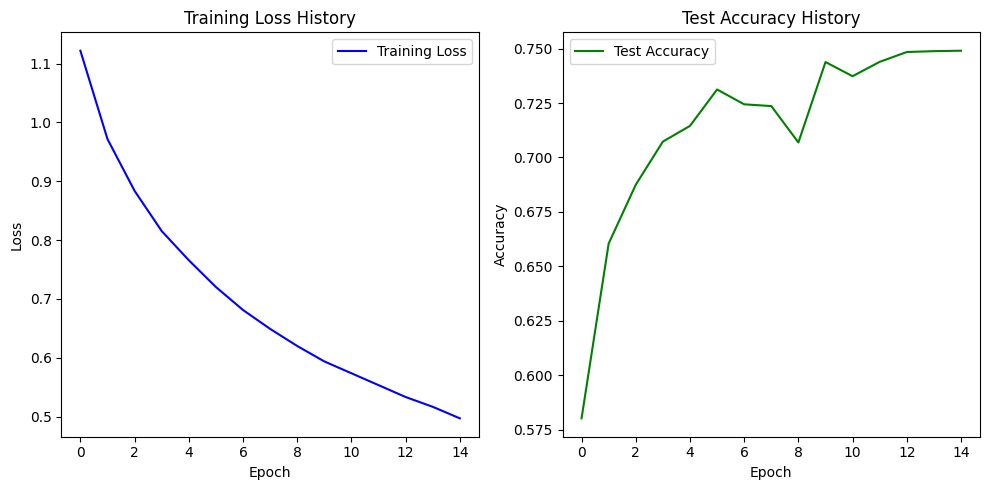

In [ ]:

# Plot the training loss history
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_hist, label='Training Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss History')
plt.legend()

# Plot the test accuracy history
plt.subplot(1, 2, 2)
plt.plot(test_hist, label='Test Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Test Accuracy History')
plt.legend()

plt.tight_layout()
plt.show()

## Task 2: Image Reconstruction and Denoising



Load the MNIST dataset into memory from `torchvision.datasets`. Our first task is to create a hierarchical Linear model that sequentially reduces the spatial dimensions of the images, encodes/compresses them from `28x28` images to just `10` features in a compact latent space representation, and then reconstruct the images using those 10 features. This type of an Encoder-Decoder architecture can be efficiently used for image compression (although there's a computational overhead)

In [8]:
# Code here
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST(root=data_path, train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_dataset = datasets.MNIST(root=data_path, train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


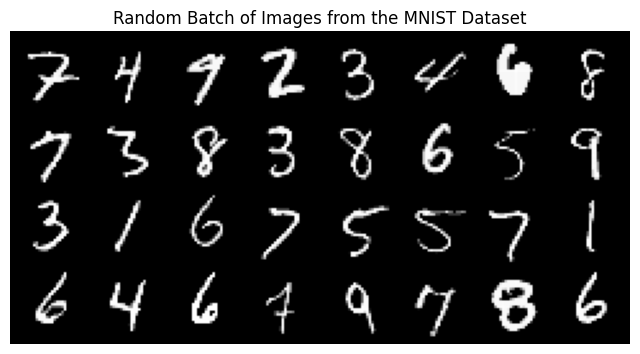

In [9]:
# Visualizing stuff:
def imshow(img):
    img = img
    npimg = img.numpy()
    plt.figure(figsize=(8, 8))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.title("Random Batch of Images from the MNIST Dataset")
    plt.show()

# Get a batch of training data
dataiter = iter(train_loader)
images, _ = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images[0:32]))

In [78]:
class LinearAutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 15)
        )
        self.decoder = nn.Sequential(
            nn.Linear(15, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28*28),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        x = x.view(x.size(0), 1, 28, 28)
        return x


#### Define a function that adds Gaussian noise to images (remember to clamp the values b/w 0 and 1) in `helper.py`

### Write the training loop for unsupervised training in `helper.py`

**Note**: It'll be very similar to the supervised training loop, so feel free to copy that and make the necessary changes

For denoising, add noise to your image before passing it to the model. You must use the default parameters of the `noisy_images` function

In [79]:
model = LinearAutoEncoder()
summary(model.to(device), input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 128]         100,480
              ReLU-3                  [-1, 128]               0
            Linear-4                   [-1, 64]           8,256
              ReLU-5                   [-1, 64]               0
            Linear-6                   [-1, 32]           2,080
              ReLU-7                   [-1, 32]               0
            Linear-8                   [-1, 15]             495
            Linear-9                   [-1, 32]             512
             ReLU-10                   [-1, 32]               0
           Linear-11                   [-1, 64]           2,112
             ReLU-12                   [-1, 64]               0
           Linear-13                  [-1, 128]           8,320
             ReLU-14                  [

### Train your model. Use MSELoss & AdamW optimizer

In [80]:
# Code here
# Instantiate your LinearAutoEncoder model
model = LinearAutoEncoder().to(device)

# Define criterion (loss function)
criterion = nn.MSELoss()

# Define optimizer
optimizer = optim.AdamW(model.parameters(), lr=0.00005)  # Adjust learning rate as needed

# Train the model
num_epochs = 25  # Adjust as needed

# model_path = fr"/content/drive/MyDrive/DL/PA3/model/LAE_PA3_24100238.pth"
model_path = fr"model/LAE_PA3_24100238.pth"

train_loss_history, test_loss_history = training_loop_unsupervised(model, 'reconstruction', train_loader, test_loader, num_epochs, criterion, optimizer, device, model_path)

print("Training finished!")

Epoch [1/25], Train Loss: 1.0085, Test Loss: 0.9257
Epoch [2/25], Train Loss: 0.9248, Test Loss: 0.9219
Epoch [3/25], Train Loss: 0.9205, Test Loss: 0.9197
Epoch [4/25], Train Loss: 0.9198, Test Loss: 0.9194
Epoch [5/25], Train Loss: 0.9195, Test Loss: 0.9191
Epoch [6/25], Train Loss: 0.9191, Test Loss: 0.9184
Epoch [7/25], Train Loss: 0.9169, Test Loss: 0.9155
Epoch [8/25], Train Loss: 0.9153, Test Loss: 0.9143
Epoch [9/25], Train Loss: 0.9142, Test Loss: 0.9129
Epoch [10/25], Train Loss: 0.9128, Test Loss: 0.9116
Epoch [11/25], Train Loss: 0.9116, Test Loss: 0.9103
Epoch [12/25], Train Loss: 0.9099, Test Loss: 0.9078
Epoch [13/25], Train Loss: 0.9078, Test Loss: 0.9063
Epoch [14/25], Train Loss: 0.9067, Test Loss: 0.9052
Epoch [15/25], Train Loss: 0.9057, Test Loss: 0.9042
Epoch [16/25], Train Loss: 0.9050, Test Loss: 0.9034
Epoch [17/25], Train Loss: 0.9041, Test Loss: 0.9024
Epoch [18/25], Train Loss: 0.9029, Test Loss: 0.9009
Epoch [19/25], Train Loss: 0.9015, Test Loss: 0.8994
Ep

### Plot the test loss history

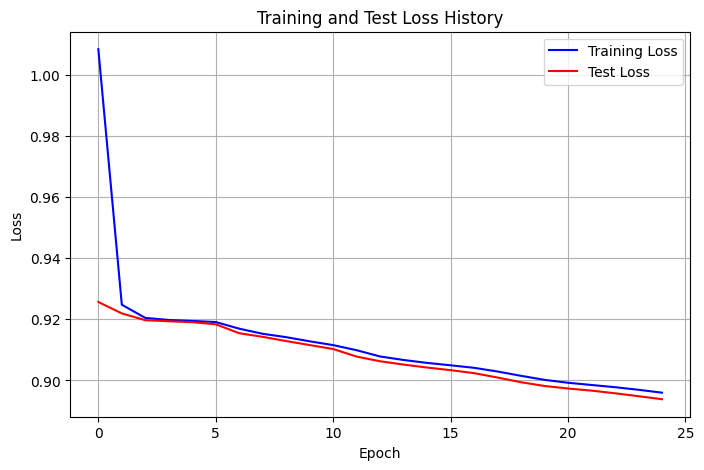

In [81]:
# Code here
plt.figure(figsize=(8, 5))
plt.plot(train_loss_history, label='Training Loss', color='blue')
plt.plot(test_loss_history, label='Test Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss History')
plt.legend()
plt.grid(True)
plt.show()

### Visualizing the model's reconstructions:

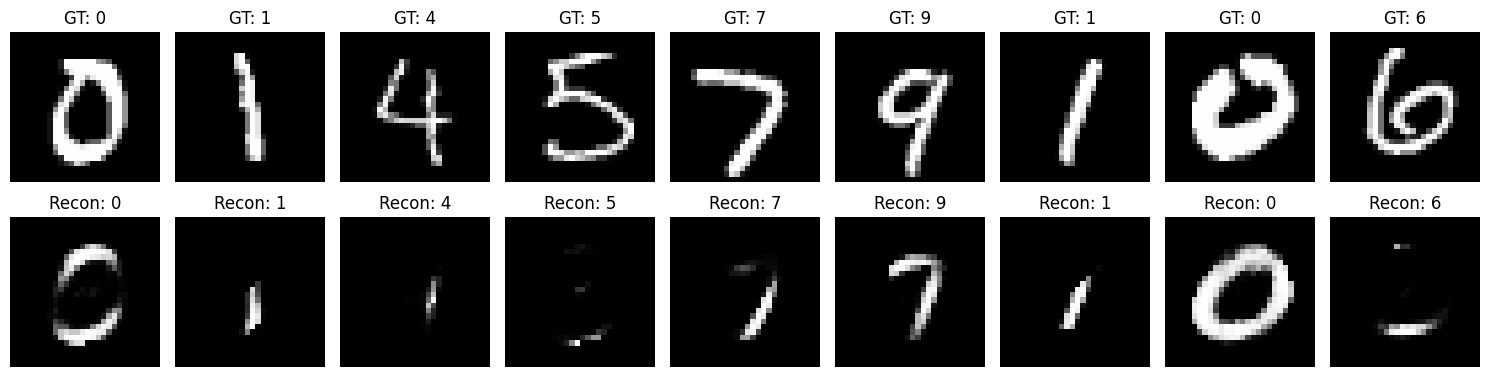

In [82]:

visualize_reconstructions(test_loader, model, device, 'reconstruction')

### Now do denoising using a new instance of the LinearAutoEncoder class

In [83]:
# 0.00001  --> 0.9247 loss
# 0.000008 --> 0.9257
# 0.00005  --> Epoch [15/15], Train Loss: 0.9218, Test Loss: 0.9218
# Code here
# Instantiate a new instance of the LinearAutoEncoder class
denoising_model = LinearAutoEncoder().to(device)

# # Load the trained weights into the new model instance
# denoising_model.load_state_dict(torch.load(model_path))

# Define criterion (loss function)
criterion = nn.MSELoss()

# Define optimizer
optimizer = optim.AdamW(denoising_model.parameters(), lr=0.00005)  # Adjust learning rate as needed

# Train the model
num_epochs = 20  # Adjust as needed

model_path = fr"model/LAE_denoising_PA3_24100238.pth"

train_loss_history, test_loss_history = training_loop_unsupervised(denoising_model, 'denoising', train_loader, test_loader, num_epochs, criterion, optimizer, device, model_path)

print("Training finished!")


Epoch [1/15], Train Loss: 1.0342, Test Loss: 0.9258
Epoch [2/15], Train Loss: 0.9254, Test Loss: 0.9258
Epoch [3/15], Train Loss: 0.9253, Test Loss: 0.9257
Epoch [4/15], Train Loss: 0.9253, Test Loss: 0.9256
Epoch [5/15], Train Loss: 0.9248, Test Loss: 0.9245
Epoch [6/15], Train Loss: 0.9234, Test Loss: 0.9228
Epoch [7/15], Train Loss: 0.9223, Test Loss: 0.9222
Epoch [8/15], Train Loss: 0.9220, Test Loss: 0.9218
Epoch [9/15], Train Loss: 0.9216, Test Loss: 0.9216
Epoch [10/15], Train Loss: 0.9214, Test Loss: 0.9215
Epoch [11/15], Train Loss: 0.9213, Test Loss: 0.9214
Epoch [12/15], Train Loss: 0.9212, Test Loss: 0.9212
Epoch [13/15], Train Loss: 0.9211, Test Loss: 0.9211
Epoch [14/15], Train Loss: 0.9210, Test Loss: 0.9210
Epoch [15/15], Train Loss: 0.9209, Test Loss: 0.9209
Training finished!
Training finished!


#### Plot the test loss history

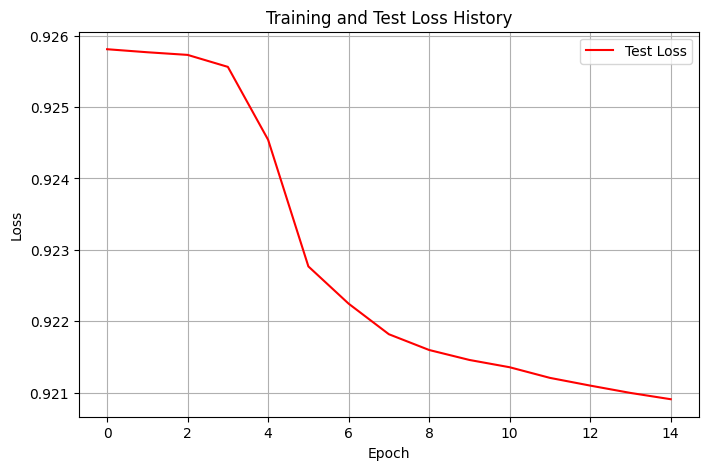

In [84]:
# Code here
plt.figure(figsize=(8, 5))
# plt.plot(train_loss_history, label='Training Loss', color='blue')
plt.plot(test_loss_history, label='Test Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss History')
plt.legend()
plt.grid(True)
plt.show()

### Visualizing the Denoising

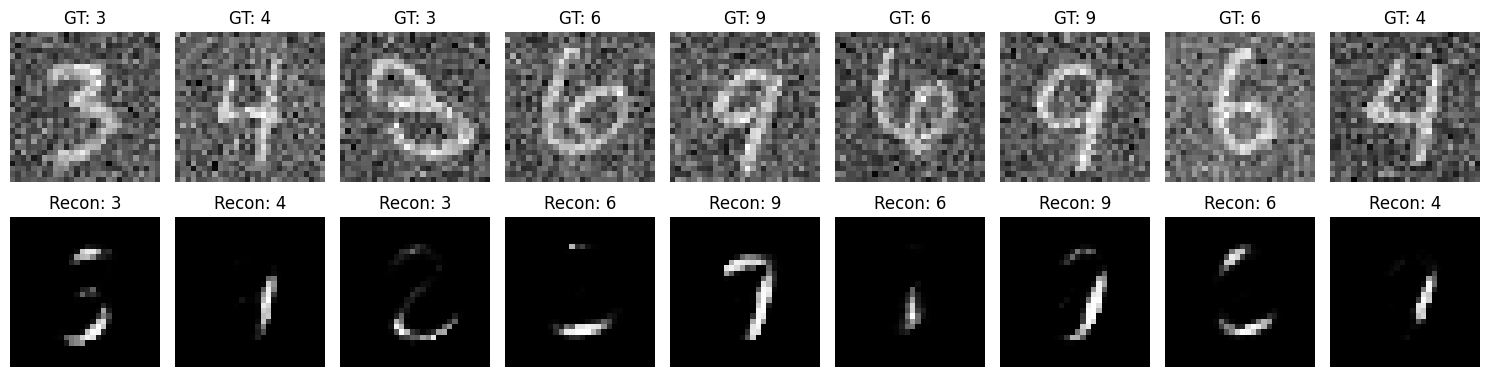

In [85]:
visualize_reconstructions(test_loader, model, device, 'denoising')

#### A massive drawback of a simple linear architecture is that we lose a ton of spatial information of the image when we flatten it. Moreover, treating each pixel as one input has a massive computational overhead, especially when you're dealing with higher resolution images (e.g., in ImageNET, the 3x224x224 images would lead to 150,528 inputs!). You might even see some poor denoising by this model. Generally, for image data, convolutional architectures are far more popular, and you'll see why in this next part.

Using the Convolutional Encoder-Decoder Model described in the instructions, do both image reconstruction and denoising

In [23]:
class AutoEncoder_CNN(nn.Module):
    def __init__(self):
        super(AutoEncoder_CNN, self).__init__()
        # Define encoder layers
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(8, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=5, stride=2, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)
        )
        self.unpool = nn.MaxUnpool2d(kernel_size=2, stride=2)
        # Define decoder layers
        self.decoder = nn.Sequential(
            # nn.MaxUnpool2d(kernel_size=2, stride=2),
            nn.ConvTranspose2d(32, 16, kernel_size=5, stride=2, padding=2),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 8, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(8, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        # Encoder
        x, indices = self.encoder(x)
        # Decoder
        out = self.unpool(x, indices)
        x = self.decoder(out)
        return x

In [22]:
model = AutoEncoder_CNN()
summary(model.to(device), input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 14, 14]              80
              ReLU-2            [-1, 8, 14, 14]               0
            Conv2d-3             [-1, 16, 7, 7]           1,168
              ReLU-4             [-1, 16, 7, 7]               0
            Conv2d-5             [-1, 32, 4, 4]          12,832
              ReLU-6             [-1, 32, 4, 4]               0
         MaxPool2d-7  [[-1, 32, 2, 2], [-1, 32, 2, 2]]               0
       MaxUnpool2d-8             [-1, 32, 4, 4]               0
   ConvTranspose2d-9             [-1, 16, 7, 7]          12,816
             ReLU-10             [-1, 16, 7, 7]               0
  ConvTranspose2d-11            [-1, 8, 14, 14]           1,160
             ReLU-12            [-1, 8, 14, 14]               0
  ConvTranspose2d-13            [-1, 1, 28, 28]              73
          Sigmoid-14            

Train your model:

In [12]:
# Code here
# changed lr from 0.00001 to 0.000005 Epoch [10/10], Train Loss: 0.9288, Test Loss: 0.9282
# 25 epochs 0.000003 lr --> Epoch [25/25], Train Loss: 0.9499, Test Loss: 0.9479

# +CE Loss

# Instantiate the model
model = AutoEncoder_CNN().to(device)

# Define loss function
criterion = nn.MSELoss()

# Define optimizer
optimizer = optim.Adam(model.parameters(), lr=0.00001)

# Define number of epochs
num_epochs = 30

model_path = fr"model/AutoEncoder_CNN_PA3_24100238.pth"

train_loss_history, test_loss_history = training_loop_unsupervised(model, 'reconstruction', train_loader, test_loader, num_epochs, criterion, optimizer, device, model_path)

print("Training finished!")

Epoch [1/30], Train Loss: 0.4252, Test Loss: 0.3129
Epoch [2/30], Train Loss: 0.2899, Test Loss: 0.2819
Epoch [3/30], Train Loss: 0.2740, Test Loss: 0.2699
Epoch [4/30], Train Loss: 0.2596, Test Loss: 0.2511
Epoch [5/30], Train Loss: 0.2363, Test Loss: 0.2216
Epoch [6/30], Train Loss: 0.2005, Test Loss: 0.1787
Epoch [7/30], Train Loss: 0.1602, Test Loss: 0.1428
Epoch [8/30], Train Loss: 0.1323, Test Loss: 0.1194
Epoch [9/30], Train Loss: 0.1120, Test Loss: 0.1017
Epoch [10/30], Train Loss: 0.0970, Test Loss: 0.0891
Epoch [11/30], Train Loss: 0.0862, Test Loss: 0.0798
Epoch [12/30], Train Loss: 0.0777, Test Loss: 0.0723
Epoch [13/30], Train Loss: 0.0710, Test Loss: 0.0663
Epoch [14/30], Train Loss: 0.0655, Test Loss: 0.0615
Epoch [15/30], Train Loss: 0.0610, Test Loss: 0.0575
Epoch [16/30], Train Loss: 0.0574, Test Loss: 0.0543
Epoch [17/30], Train Loss: 0.0544, Test Loss: 0.0516
Epoch [18/30], Train Loss: 0.0519, Test Loss: 0.0493
Epoch [19/30], Train Loss: 0.0497, Test Loss: 0.0473
Ep

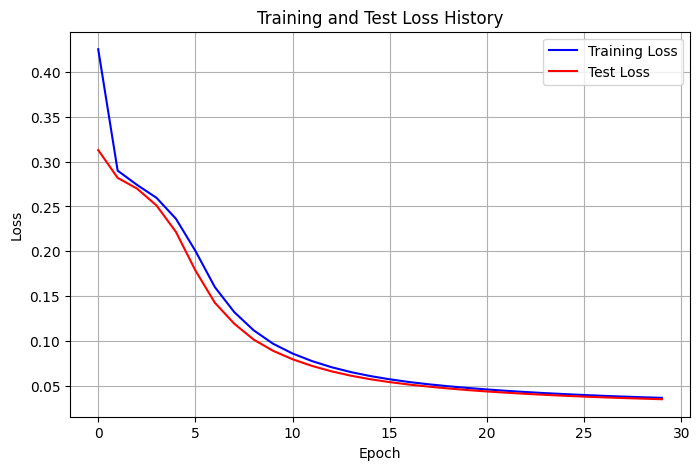

In [13]:
# Code here
plt.figure(figsize=(8, 5))
plt.plot(train_loss_history, label='Training Loss', color='blue')
plt.plot(test_loss_history, label='Test Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss History')
plt.legend()
plt.grid(True)
plt.show()

## Visualization

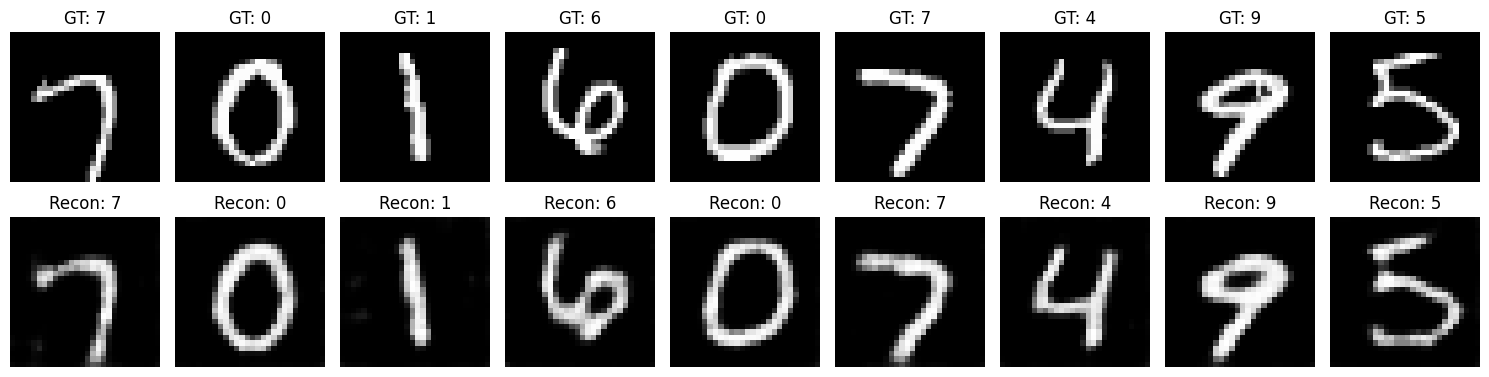

In [14]:
visualize_reconstructions(test_loader, model, device, 'reconstruction')

### Now do the same for Denoising:

In [18]:
# Code here
denoising_model = AutoEncoder_CNN()

# Define loss function
criterion = nn.MSELoss()

# Define optimizer
optimizer = optim.Adam(denoising_model.parameters(), lr=0.00001)

# Define number of epochs
num_epochs = 30

model_path = fr"model/AutoEncoder_CNN_denoising_PA3_24100238.pth"

train_loss_history, test_loss_history = training_loop_unsupervised(denoising_model, 'denoising', train_loader, test_loader, num_epochs, criterion, optimizer, device, model_path)

print("Training finished!")


Epoch [1/30], Train Loss: 1.1468, Test Loss: 0.6931
Epoch [2/30], Train Loss: 0.5155, Test Loss: 0.4345
Epoch [3/30], Train Loss: 0.3844, Test Loss: 0.3555
Epoch [4/30], Train Loss: 0.3330, Test Loss: 0.3146
Epoch [5/30], Train Loss: 0.2985, Test Loss: 0.2878
Epoch [6/30], Train Loss: 0.2799, Test Loss: 0.2753
Epoch [7/30], Train Loss: 0.2701, Test Loss: 0.2658
Epoch [8/30], Train Loss: 0.2600, Test Loss: 0.2543
Epoch [9/30], Train Loss: 0.2464, Test Loss: 0.2382
Epoch [10/30], Train Loss: 0.2299, Test Loss: 0.2203
Epoch [11/30], Train Loss: 0.2117, Test Loss: 0.2004
Epoch [12/30], Train Loss: 0.1913, Test Loss: 0.1793
Epoch [13/30], Train Loss: 0.1710, Test Loss: 0.1602
Epoch [14/30], Train Loss: 0.1536, Test Loss: 0.1441
Epoch [15/30], Train Loss: 0.1382, Test Loss: 0.1286
Epoch [16/30], Train Loss: 0.1238, Test Loss: 0.1156
Epoch [17/30], Train Loss: 0.1118, Test Loss: 0.1046
Epoch [18/30], Train Loss: 0.1020, Test Loss: 0.0957
Epoch [19/30], Train Loss: 0.0940, Test Loss: 0.0886
Ep

### Plot the test_loss history

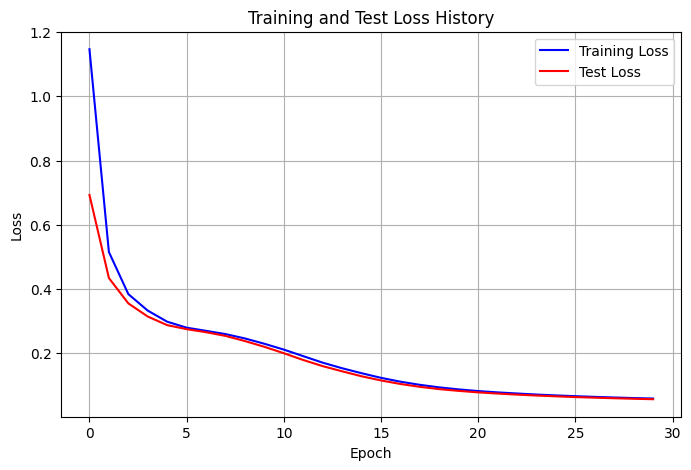

In [19]:
# Code here
plt.figure(figsize=(8, 5))
plt.plot(train_loss_history, label='Training Loss', color='blue')
plt.plot(test_loss_history, label='Test Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss History')
plt.legend()
plt.grid(True)
plt.show()

### Visualizing the Denoising of the Convolutional AE model

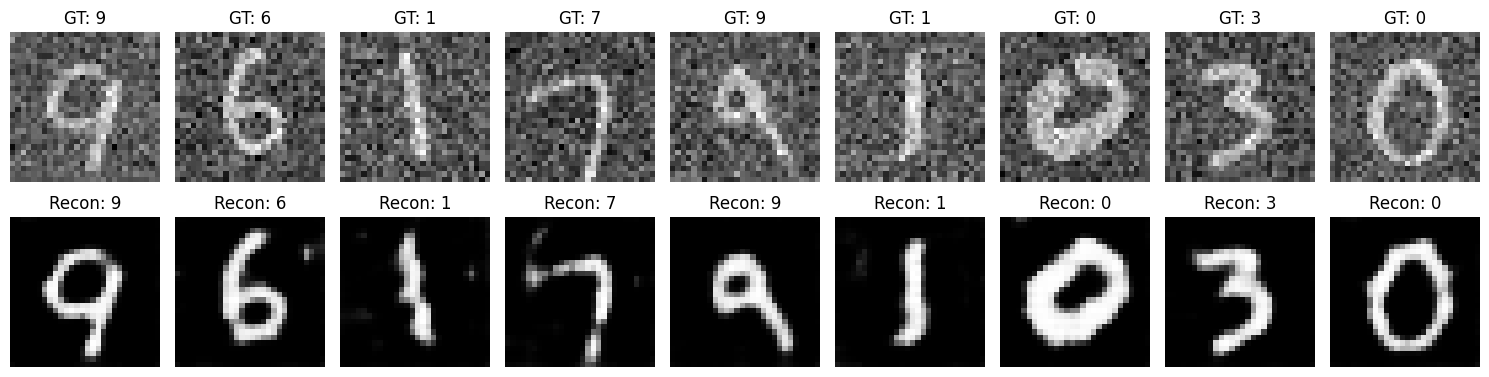

In [20]:
visualize_reconstructions(test_loader, model, device, 'denoising')

Clearly far better, right? And with much less parameters!

#### Compare the number of parameters of both models, and comment on how/why a convolutional neural network performs so much better on image data compared to a fully connected network while using far less parameters.

- Answer here: Number of params in FC were 200k and in CNN, they were 20k. In CNNs, the same set of weights (parameters) is used across different parts of the input image. This parameter sharing allows the network to learn local patterns, extraction of features and heirarchial representation that are important for recognizing objects in images, while drastically reducing the number of parameters compared to a fully connected network where each neuron is connected to every neuron in the previous layer (overfeeding the next neuron with extra unneccesary info and increased computational aoverhead with momre number of parameters) and it doesn't pass on the actual features to the next layer.